# scikit-learn

## Overview

Scikit-learn [R] is a Python package containing a wide selection of tools for machine learning. Machine learning is a technique of using computers to make predictions on unseen data based on either previously seen data or algorithms which find patterns within data. In addition to a large collection of data analysis algorithms, the package also provides tools for data preprocessing and dimensionality reduction; model selection and hyperparameter tuning - that is, finding an algorithm and a set of parameters to that algorithm that enable it to best perform on a particular dataset.

1. Organisation of package
1. Consistent API -- `transform()`, `fit()`, `fit_transform()`, `predict`, etc
1. Pipelines and Grid / Randomised search



## Imports

The following code cells import all the libraries necessary to run this notebook. As there are a lot of imports, they are divided into four cells according to their function for easier management. 

In [1]:
# General utilities

# file management
import os
# downloading datasets
import requests
# url construction
from urllib.parse import urljoin
# quick tables
from tabulate import tabulate
# like zip but doesn't truncate
from itertools import zip_longest

In [2]:
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

In [75]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.base import TransformerMixin
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## The Wine Quality Dataset
The wine quality dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), consists of two semicolon-delimited files, one relating to Portuguese *Vinho Verde* red wines and one to whites. The datasets were produced by [Cortez et al.][cortezetal] in order to assess various machine learning algorithms in prediction of the quality of a wine from its properties. They considered support vector machines (SVM), multiple regression analysis, and neural networks. Of these the best performance was achieved using SVM [RPaper,RDatasheet].

Twelve attributes are recorded for each wine sample; eleven are objective physical or chemical attributes, and one, `quality`, is a subjective assessment of the wine's quality. The `quality` attribute is recorded as a value from 0 (poorest quality) to 10 (best quality) and is derived from the median score assigned to it by at least three experts [RDatasheet].

The data information sheet distributed with the data [R] notes that several attributes may be correlated and that not all attributes necessarily affect quality and suggests that feature selection may be advisable. The datasheet also suggests that the problem of wine quality prediction may be cast as a regression problem or as a classification problem.

### Procedure

1. [Acquire the data](#Acquire-the-dataset)
1. [Split the data](#Split-the-data)
1. [Explore the data](#Explore-the-dataset)
    1. [View a sample of each dataset](#View-the-data)
    1. [View the distribution of each feature](#View-the-distribution-of-each-feature)
    1. [View distribution of target variable](#View-distribution-of-target-variable)
    1. [View correlations between features](#View-feature-correlations)
    1. [Assess relative influence of each feature on the target variable](#Assess-relative-influence-of-each-feature-on-the-target-variable)
1. [Feature scaling](#Feature-scaling)
1. [Dimensionality reduction](#Dimensionality-reduction)
    1. [Feature selection](#Feature-selection)
    1. [Principal Components Analysis](#Principal-components-analysis-(PCA))
    1. [Kernel PCA](#Kernel-PCA)
1. [Model selection](#Model-selection)
    1. Decide on whether the problem will be cast as binary classification, multiclass classification, or regression
    1. Adjust target variable as necessary
    1. Select some suitable models
1. [Hyperparameter tuning](#Hyperparameter-tuning)
    1. [Pipelines](#Pipelines)
    2. [Grid Search](#Grid-search)
1. Fit and assess models
    1. Fit each model/hyperparameter/featureset combination
    1. Conduct assessment appropriate to each combination
    1. Select best candidates and fine tune
1. Test predictions
    1. Use trained model(s) to predict test set
    2. Assess model performance on test set


### Acquire the dataset
The dataset is downloaded as two semicolon delimited files from the UCI Machine Learning Repository and saved to disc. 

In [5]:
# Location of wine quality dataset
base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# Local data directory
data_dir = 'data/wine/'

# Names of dataset files to be downloaded
source_files = ('winequality-red.csv', 'winequality-white.csv', 'winequality.names')

# for each of the source files construct url, 
# fetch file, and write to data directory
for datafile in (source_files):
    response = requests.get(urljoin(base_url, datafile))
    with open(os.path.join(data_dir, datafile), 'wb') as f:
        f.write(response.content)

The data is then loaded into two pandas dataframes, one for the red wine dataset and one for the white.

In [6]:
# Load red wine and white wine datasets into pandas DataFrames
redwine = pd.read_csv('data/wine/winequality-red.csv', delimiter=";")
whitewine = pd.read_csv('data/wine/winequality-white.csv', delimiter=";")

## Split the data
Each of the two wine datasets is split into a training set, representing 80% of the data, and a test set, representing the other 20%. The data is shuffled before splitting and the split is stratified on the `quality` output variable. This ensures that each category is proportionally represented in both the training and test sets. It is necessary to do this because, as noted [below](#View-distribution-of-target-variable), the target variable is unevenly distributed. The input features are also split from the target variable in both the training and testing sets. The input feature DataFrame names are prefixed with an `X` and the targets with a `y`. The split is conducted using `sklearn.model_selection.train_test_split()` [5].

In [7]:
# Merge quality ratngs so that 3,4 = 0 (low), 5,6 = 1 (medium), 7,8,9 = 2 (high)
for w in redwine, whitewine:
    w['quality_cat'] = np.where(w['quality'] <= 4, 0, np.where(w['quality'] >= 7, 2, 1))

In [8]:
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_rw, X_test_rw, y_train_rw, y_test_rw = \
    train_test_split(redwine.drop('quality', axis=1), redwine['quality'], stratify=redwine['quality'], test_size=0.2)
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_ww, X_test_ww, y_train_ww, y_test_ww = \
    train_test_split(whitewine.drop('quality', axis=1), whitewine['quality'], stratify=whitewine['quality'], test_size=0.2)

In [9]:
X_train_rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
959,8.0,0.59,0.05,2.0,0.089,12.0,32.0,0.99735,3.36,0.61,10.0,1
332,8.0,0.58,0.28,3.2,0.066,21.0,114.0,0.99730,3.22,0.54,9.4,1
1466,7.3,0.48,0.32,2.1,0.062,31.0,54.0,0.99728,3.30,0.65,10.0,2
1386,7.4,0.64,0.07,1.8,0.100,8.0,23.0,0.99610,3.30,0.58,9.6,1
565,12.7,0.60,0.49,2.8,0.075,5.0,19.0,0.99940,3.14,0.57,11.4,1


In [10]:
# Create new train and test y values from the quality_cat column 
# and remove the column from the X value datasets
# Red wine
y_train_cat_rw, y_test_cat_rw = X_train_rw['quality_cat'], X_test_rw['quality_cat']
X_train_rw, X_test_rw = X_train_rw.drop('quality_cat', axis=1), X_test_rw.drop('quality_cat', axis=1)

# White wine
y_train_cat_ww, y_test_cat_ww = X_train_ww['quality_cat'], X_test_ww['quality_cat']
X_train_ww, X_test_ww = X_train_ww.drop('quality_cat', axis=1), X_test_ww.drop('quality_cat', axis=1)

## Explore the dataset
Two DataFrames are created, `rw` and `ww`, representing The red wine and white wine datasets respectively. They are subset from the original full datasets as loaded from csv using the training set indices. They will be used to explore the data. The instances in the test subsets must remain unseen if the analysis is to remain unbiased by their contents.

In [11]:
rw = redwine.iloc[X_train_rw.index]
ww = whitewine.iloc[X_train_ww.index]
# Give the DataFrames name attributes for quick labelling of output
rw.name, ww.name = "Red Wine", "White Wine"

### View the data
The first five rows of each of the two DataFrames are viewed using `pandas.DataFrame.head()`. This gives a general idea of the structure of the dataset.

In [12]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.head())

-----------
Red Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
959,8.0,0.59,0.05,2.0,0.089,12.0,32.0,0.99735,3.36,0.61,10.0,5,1
332,8.0,0.58,0.28,3.2,0.066,21.0,114.0,0.99730,3.22,0.54,9.4,6,1
1466,7.3,0.48,0.32,2.1,0.062,31.0,54.0,0.99728,3.30,0.65,10.0,7,2
1386,7.4,0.64,0.07,1.8,0.100,8.0,23.0,0.99610,3.30,0.58,9.6,5,1
565,12.7,0.60,0.49,2.8,0.075,5.0,19.0,0.99940,3.14,0.57,11.4,5,1


-----------
White Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
511,7.8,0.34,0.35,1.80,0.042,8.0,167.0,0.99080,3.11,0.41,12.1,6,1
4476,6.0,0.20,0.38,1.30,0.034,37.0,104.0,0.98865,3.11,0.52,12.7,6,1
3493,6.0,0.28,0.27,15.50,0.036,31.0,134.0,0.99408,3.19,0.44,13.0,7,2
1011,7.7,0.16,0.41,1.70,0.048,60.0,173.0,0.99320,3.24,0.66,11.2,7,2
4030,6.9,0.19,0.38,1.15,0.023,30.0,105.0,0.99047,3.11,0.38,11.4,5,1


***

The `DataFrame.info()` function returns the name, count, and datatype of each feature in the DataFrame. Each of the two wine datasets consists of 11 input variables of type `float64` and one output variable of type `int64`. The red wine data contains 1279 samples (1599 including the test set)  and the white wine data contains 3918 (4898 including the test set). Neither has any missing values.

In [13]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    print(w.info())

-----------
Red Wine
-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 959 to 443
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
 12  quality_cat           1279 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 139.9 KB
None
-----------
White Wine
-----------
<

***

The `DataFrame.describe()` function returns a table containing descriptive statistics for each of the features.

In [14]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.describe().round(2))

-----------
Red Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.33,0.53,0.27,2.53,0.09,15.76,46.57,1.00,3.31,0.66,10.41,5.64,1.10
std,1.75,0.18,0.20,1.41,0.05,10.40,32.62,0.00,0.15,0.18,1.08,0.81,0.41
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00,0.00
25%,7.10,0.40,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00,1.00
50%,7.90,0.52,0.26,2.20,0.08,13.00,38.00,1.00,3.30,0.62,10.10,6.00,1.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,63.00,1.00,3.40,0.73,11.10,6.00,1.00
max,15.90,1.58,1.00,15.50,0.61,68.00,289.00,1.00,4.01,2.00,14.90,8.00,2.00


-----------
White Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
count,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00
mean,6.85,0.28,0.33,6.36,0.05,35.15,137.99,0.99,3.19,0.49,10.51,5.88,1.18
std,0.85,0.10,0.12,5.08,0.02,17.00,42.06,0.00,0.15,0.11,1.23,0.89,0.47
min,3.90,0.08,0.00,0.60,0.01,2.00,9.00,0.99,2.72,0.22,8.00,3.00,0.00
25%,6.30,0.21,0.27,1.70,0.04,23.00,108.00,0.99,3.09,0.41,9.50,5.00,1.00
50%,6.80,0.26,0.31,5.18,0.04,34.00,134.00,0.99,3.18,0.47,10.40,6.00,1.00
75%,7.30,0.32,0.38,9.80,0.05,46.00,167.00,1.00,3.28,0.55,11.40,6.00,1.00
max,14.20,1.00,1.66,65.80,0.35,289.00,440.00,1.04,3.80,1.08,14.20,9.00,2.00


***

### View the distribution of each feature

`DataFrame.hist()` produces a histogram for each feature which can be displayed with `plt.show()`. Some points to note are:
- It looks like `citric acid` in the red wine dataset, and `residual sugar` in the white wine dataset contain a lot of zero values.
- A number of features have very long tails, in particular `residual sugar`, `chlorides`, `total sulfur dioxide`, and `sulphates`.
- There is considerable variation in the attributes' scales.
- The target values are very unevenly distributed with a great many more instances falling around the medium quality ratings than the low and high ratings.

[4] 50-51

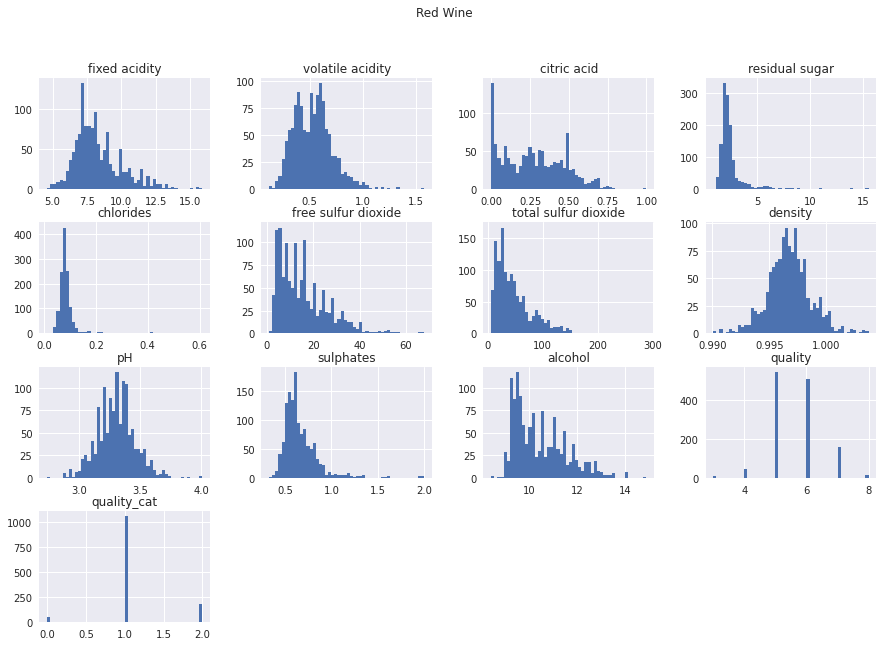

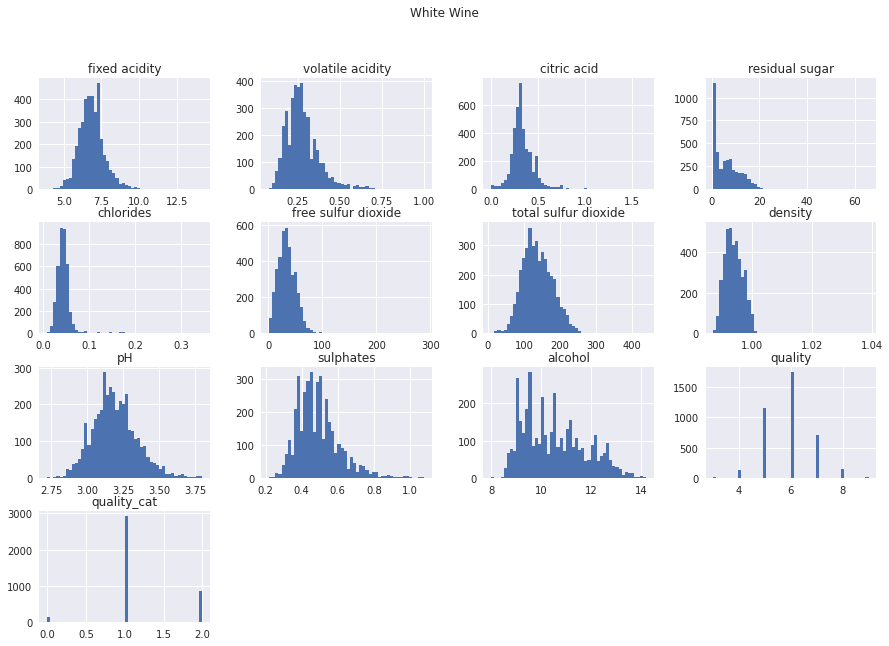

In [15]:
# View a histogram of each feature
for w in rw, ww:
    # Set plot style
    with plt.style.context('seaborn'):
        # Construct histogram with 50 bins for each feature
        hist = w.hist(bins=50, figsize=(15, 10))
        # Title for each set of histograms
        plt.gcf().suptitle(w.name)
    plt.show()

***

### View distribution of target variable
The target variable in this dataset is `quality`. As is obvious from the histograms above, the distribution of the output variable heavily favours the central categories. The red wine dataset is sorted into six ordinal categories from 3 to 8. Categories `5` and `6` represent over 80% of the data. The lowest category, `3`, occurs in only 8 instances, representing 0.6% of the dataset; `4` occurs 42 times  - 1.1% of total ratings. At the upper end of the scale `7` occurs 159 times or ~12% and just 15 red wines, ~1%, hold the higest rating of `8`. 

The white wine dataset shows a similar imbalance. Of its 7 rating categories, 3 to 8, over 90 % fall into the medium group, `5`, `6`, and `7`. Categories `3` and `4` account for a combined 4% of instances, with just 16 wines with a rating of `3`. Similarly, `8` and `9` occur in less than 4% of samples; `9` only occurring 4 times.



In [16]:
# Count occurences of each quality class and calculate percents of total
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # Count occurrences of each category
    wc = w.quality.value_counts()
    # Calculate percent of total number of samples
    wp = round(w.quality.value_counts() / len(w) * 100, 2)
    # Place in dataframe for ease of presentation and display
    df = pd.concat((wc,wp), axis=1)
    df.columns = ('Count', 'Percent')
    print(df)

-----------
Red Wine
-----------
   Count  Percent
5    545    42.61
6    510    39.87
7    159    12.43
4     42     3.28
8     15     1.17
3      8     0.63
-----------
White Wine
-----------
   Count  Percent
6   1758    44.87
5   1166    29.76
7    704    17.97
8    140     3.57
4    130     3.32
3     16     0.41
9      4     0.10


***

### View feature correlations

For each of the wine datasets (red and white), a correlation matrix is calculated using *pandas* `DataFrame.corr()` function. The correlation coefficient is calcualted between each pair of numeric variables using Pearson's r. The resulting matrices are displayed as heatmaps using `seaborn.heatmap()`. The colourmap used is set to saturate at a correlation coefficient of 0.5 so that high correlations are very obvious. For the same reason the diagonal of the correlation matrix, which always holds a 1.0 as it is the value of a feature's correlation with itself, is removed.

The correlation heatmaps reveal the following:

- In the red wine dataset:
    - `Fixed acidity` is strongly correlated with each of `citric acid`, `density`, and `pH`
    - `Volatile acidity` is moderately correlated with `citric acid`
    - `Citric acid`, in addtion to it's correlations with `fixed acidity` and `volatile acidity`, also displays a moderate correlation with `pH`
    - `Total sulfur dioxide` and `free sulfur dioxide` are highly correlated
    - `Density` has a correlation of 0.49 with `alcohol`
    
- In the white wine dataset:
    - `Fixed acidity` is correlated with `pH`
    - `residual sugar` is highly correlated with `density` and, to a lesser extent, `alcohol`
    - `Total sulfur dioxide` and `free sulfur dioxide` are quite highly correlated
    - `Total sulfur dioxide` is also correlated with `density` and, more weakly with `alcohol`
    - `density`, in addition to its correlation with `residual sugar` and `total sulfur dioxide`, is highly correlated with `alcohol`

Finally, correlation with `quality` shows which attributes have the strongest influence on the output variable. These relationships are discussed below.

-----------
Red Wine
-----------


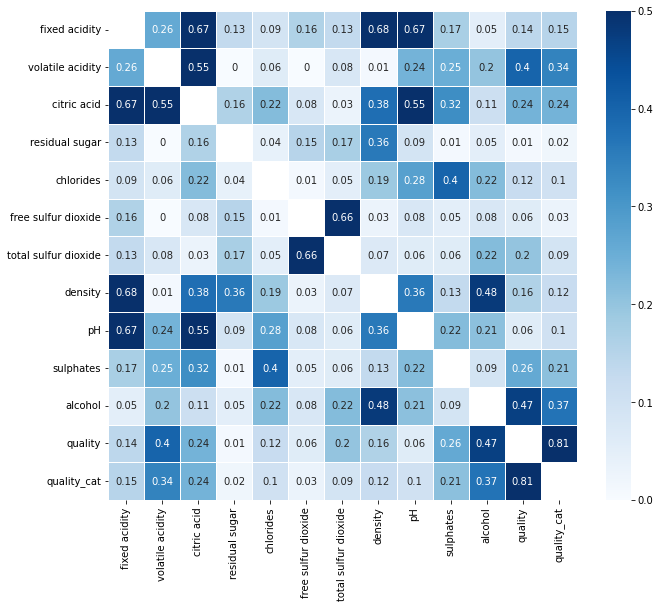

-----------
White Wine
-----------


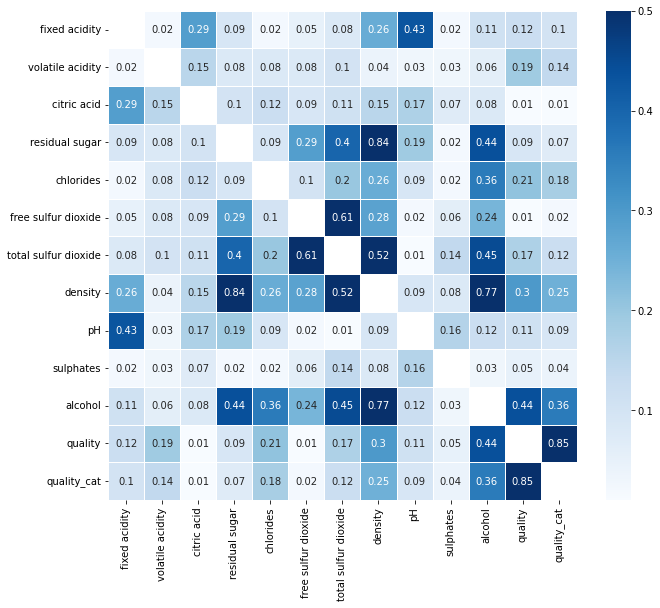

In [17]:
# Set figure size within context so it doesn't affect size of subsequent figures
with plt.rc_context({'figure.figsize':(10.5,9)}):
    # For each or red win and white wine dataframes
    for w in rw, ww:
        # Print the dataframe name
        print(f"-----------\n{w.name}\n-----------")
        # Calculate correlation matrix (using Pearson's r)
        corr = w.corr()
        # Remove distracting self correlations (always = 1)
        np.fill_diagonal(corr.values, 'NaN')
        # Display matrix as heatmap, saturate at 0.5 to make high correlations stand out
        sns.heatmap(abs(corr.round(2)), annot=True, linewidths=0.5, cmap='Blues', vmax=0.5)
        plt.show()

***

### Assess relative influence of each feature on the target variable

The tables below are the the `quality` columns from the correlation matrix calculated earlier, ordered (descending) by correlation coefficient. 

The features which influence red wine `quality` are dominated by `alcohol` and `volatile acidity`, with `sulphates`, `citric acid`, `total sulfur dioxide`, `density`, `chlorides`, and `fixed acidity` having moderate to low influences. `pH`, `free sulfur dioxide`, and `residual sugar` all have a very low correlation with wine quality. White wine `quality` is most influenced by `alcohol` and `density`. `Chlorides`, `volatile acidity`, `total sulfur dioxide`, and `fixed acidity` all exhibit a moderate influence, while `pH`, `residual sugar`, and `sulphates` show low correlation. The influences of `citric acid` and `free sulfur dioxide` are extremely low.

In [18]:
# Sort values in the correlation matrix by the absolute correlation with the target variable
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # print the sorted absolute values of the correlation between each feature and quality
    print(abs(w.corr()['quality']).drop('quality').sort_values(ascending=False))

-----------
Red Wine
-----------
quality_cat             0.812540
alcohol                 0.472043
volatile acidity        0.404031
sulphates               0.255222
citric acid             0.243064
total sulfur dioxide    0.199768
density                 0.164004
fixed acidity           0.143916
chlorides               0.119841
free sulfur dioxide     0.062847
pH                      0.061693
residual sugar          0.010542
Name: quality, dtype: float64
-----------
White Wine
-----------
quality_cat             0.850943
alcohol                 0.438449
density                 0.302705
chlorides               0.210441
volatile acidity        0.194094
total sulfur dioxide    0.170473
fixed acidity           0.115621
pH                      0.105395
residual sugar          0.089353
sulphates               0.045149
citric acid             0.007020
free sulfur dioxide     0.006760
Name: quality, dtype: float64


***

## Feature scaling

Standardisation is the process of scaling data so that it has a mean of zero and unit variance. Many classification RBF kernel of support vector machines, which may be used to classify this dataset, can be dominated by comparatively large values and are more likely to perform well on standardised data [11]. Similarly, KNN and logistic regression expect standardised data, as does PCA [8] [13]. As noted [above](#View-the-distribution-of-each-feature), a number of features have very long tails that can cause the majority of the data to be squeezed into a very small range. To counter this effect, scikit-learn provides a `RobustScaler()` which standardises the data based on the interquartile range (by default. The range used can be adjusted via `RobustScaler's` parameters). [14] [15]

In [19]:
# Instantiate StandardScaler and use to transfomr both datasets
scaler_std_rw = StandardScaler()
X_train_std_rw = scaler_std_rw.fit_transform(X_train_rw)
scaler_std_ww = StandardScaler()
X_train_std_ww = scaler_std_ww.fit_transform(X_train_ww)

# Instantiate RobustScaler and use to transform both datasets
scaler_rbst_rw = RobustScaler()
X_train_rbst_rw = scaler_rbst_rw.fit_transform(X_train_rw)
scaler_rbst_ww = StandardScaler()
X_train_rbst_ww = scaler_rbst_ww.fit_transform(X_train_ww)

# A look at the first row of each of the robust- and standard-
# scaled matrices for red wine show that the two scalers 
# produce quite different results
print(X_train_std_rw[0])
print(X_train_rbst_rw[0])

[-0.1891067   0.3276521  -1.12633787 -0.37874202  0.01604871 -0.36185736
 -0.4467748   0.32035278  0.35481403 -0.27962173 -0.3841309 ]
[ 0.04761905  0.29473684 -0.63636364 -0.28571429  0.5        -0.07142857
 -0.14634146  0.28636364  0.32432432 -0.05555556 -0.0625    ]


***

## Dimensionality reduction

The aim of dimensionality reduction is to reduce the number of input features and therefore the complexity of the problem while at the same time minimising the loss of variance between samples with different targets. There are a number of approaches to this, one of which is to simply drop features based on some criteria such as a immateriality to the problem or high correlation with another feature. Another approach entails the projection of high dimensional samples to lower dimensional space in a manner which maximises variance. This approach is exemplified by [principal components analysis (PCA)](#Principal-components-analysis-(PCA)) and [kernel PCA](#Kernel-PCA), which are considered below.

### Feature selection

Two approaches to feature selection are demonstrated in this section. Both have been place in custom transformers. This will allow them to be placed in a pipeline later. It will also allow their parameters to be tuned using a grid search. Placing logic in a custom transformer is achieved by extending the `BaseEstimator` class and implementing the constructor (`__init__`) and the `fit()` and `transform()` methods. Adding the `TransformerMixin` provides the `fit_transform()` method.

The `DropLessImportantFeatures` transformer is instantiated with a single parameter, `threshold`, which defaults to 0.1. The `fit()` method calculates the correlation between each feature and the target variable using `numpy.corrcoef()`. The `transform` method then drops any features for which that correlation is less than the `threshold`.

In [20]:
# Custom Transformer for dropping features based on correlation with output variable
# Putting this functionality in a transformer allows it to be used in a pipeline and 
# grid/randomised search hyperparameter tuning
class DropLessImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold=threshold
    def fit(self, X, y):
        # X must be a numpy array
        # Calculate correlation coefficients, only keep the last one
        # because we only want each feature's correlation with y
        self.to_drop = abs(np.corrcoef(X, y, rowvar=False)[:,-1]) < self.threshold
        return self
    def transform(self, X):
        # Remove columns (features) where correlation coefficient with
        # y (output variable) is lower than threshold
        return np.delete(X, self.to_drop[0:-1], axis=1)

In [21]:
# Use DropLessImportantFeatures transformer to drop features 
# with a correlation of less than 0.1 with the output variable 
# (quality) from the red and white wine datasets
dlif_rw = DropLessImportantFeatures()
X_train_rw_dlif = dlif_rw.fit_transform(X_train_rw.to_numpy(), y_train_rw)

dlif_ww = DropLessImportantFeatures()
X_train_ww_dlif = dlif_ww.fit_transform(X_train_ww.to_numpy(), y_train_ww)

Examining the shape attribute of the red and white wine feature arrays shows that of the original 11 features in each dataset they now each have 8. They have each dropped 3 columns but only one - `free sulfur dioxide` - was dropped by both.

In [22]:
# Print shape of new pruned arrays
print(f"Red wine dimensions:   {X_train_rw_dlif.shape}")
print(f"White wine dimensions: {X_train_ww_dlif.shape}\n")
# List the dropped columns
print("Dropped columns:")
print("----------------------------------------")
cols = zip_longest(X_train_rw.columns[dlif_rw.to_drop[0:-1]], 
           X_train_ww.columns[dlif_ww.to_drop[0:-1]])
print(tabulate(cols, headers=["Red wine", "White wine"]))
print("----------------------------------------")

Red wine dimensions:   (1279, 8)
White wine dimensions: (3918, 7)

Dropped columns:
----------------------------------------
Red wine             White wine
-------------------  -------------------
residual sugar       citric acid
free sulfur dioxide  residual sugar
pH                   free sulfur dioxide
                     sulphates
----------------------------------------


We can also try removing one of every pair of strongly correlated features. While in some ways this may be a naive mode of dimensionality reduction, it may be appropriate in some cases, particularly where it is desirable to keep the original features so that each feature's level of importance to a classification can be assessed.

The `DropCorrelatedFeatures` transformer is instantiated with a single parameter, `threshold`, which defaults to 0.5. The `fit` method calculates the absolute correlation matrix, using `numpy.corrcoef()`, for the passed array. The self-correlations along the diagonal of the matrix are set to 0. For each feature, the number of other features that it shares a greater-than-the-`threshold` correlation with is noted and the feature with the greatest number of correlations is removed. The correlation matrix is again calculated on the remaining features and the process repeated until no correlations greater than the threshold remain.

In [23]:
# Custom Transformer for dropping features based on correlation with output variable
# Putting this functionality in a transformer allows it to be used in a pipeline and 
# grid/randomised search hyperparameter tuning
class DropCorrelatedFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def fit(self, X, y=None):
        # X should be a numpy array
        # Make temp copy of X
        c = X.copy()
        
        # Calculate absolute correlation matrix for all input features
        # Loop control variable
        max_sums = -1
        # List to hold indexes of features to drop
        idxs = []
        # Loop until there are no correlations above the threshold
        while max_sums != 0:
            # Calculate absolute correlation matrix
            corr = abs(np.corrcoef(c, rowvar=False))
            # Fill diagonal with zeroes
            np.fill_diagonal(corr, 0)
            # construct boolean matrix based on threshold 
            corr = corr >= self.threshold
            # calculate number of features that correlate with each feature
            sums = np.sum(corr, axis=1)
            if max(sums) != 0:
                # get index of max value
                idx = np.argmax(sums)
                # Index in original array will not always match index in current 
                # array as one column is deleted on each iteration
                # If the new index is less than the last index then it can be used unchanged
                if len(idxs) > 0 | idx < idxs[-1]:
                    idxs.append(idx)
                # otherwise the number of removed columns must be added
                else:
                    idxs.append(idx+len(idxs))
                # Delete the column at the current index from the temporary array
                c = np.delete(c, idx, axis=1)
                # update the loop variable
            max_sums = max(sums)

        self.idxs = idxs
        return self
    
    def transform(self, X):
        # Remove columns (features) which correlate over the threshold with other features
        return np.delete(X, self.idxs, axis=1)


In [24]:
# Use DropCorrelatedFeatures transformer to drop features 
# with a correlation of greater than or equal to 0.5 with 
# with any other feature from the red and white wine datasets
dcf_rw = DropCorrelatedFeatures()
X_train_rw_dcf = dcf_rw.fit_transform(X_train_rw.to_numpy())

dcf_ww = DropCorrelatedFeatures()
X_train_ww_dcf = dcf_ww.fit_transform(X_train_ww.to_numpy())

With a correlation threshold of 0.5, the red wine dataset drops three columns, and the white wine dataset two.

In [25]:
# Print shape of new pruned arrays
print(f"Red wine dimensions:   {X_train_rw_dcf.shape}")
print(f"White wine dimensions: {X_train_ww_dcf.shape}\n")
# List the dropped columns
print("Dropped columns:")
print("----------------------------------------")
cols = zip_longest(X_train_rw.columns[dcf_rw.idxs], 
           X_train_ww.columns[dcf_ww.idxs])
print(tabulate(cols, headers=["Red wine", "White wine"]))
print("----------------------------------------")

Red wine dimensions:   (1279, 8)
White wine dimensions: (3918, 9)

Dropped columns:
----------------------------------------
Red wine             White wine
-------------------  --------------------
fixed acidity        density
citric acid          total sulfur dioxide
free sulfur dioxide
----------------------------------------


### Principal components analysis (PCA)

Principal components analysis reduces the dimensionality of a dataset by identifying the axis that preserves the maximum variance in each dimension of the data and projecting the data on those axes to a lower number of dimensions [19]. Scikit-learn's `PCA` class allows the number of desired dimensions to be specified via the `n_components` attribute. A float between 0.0 and 1.0 passed to `n_components` will be interpreted as the amount of variance to be preserved and the number of principal components necessary for this will be automatically selected.

In [26]:
# Conduct PCA on the robust-standardised datasets, preserving 95% of variance
pca_rw = PCA(n_components=0.95)
pca_ww = PCA(n_components=0.95)
X_train_pca_rw = pca_rw.fit_transform(X_train_rbst_rw)
X_train_pca_ww = pca_ww.fit_transform(X_train_rbst_ww)

Transforming the robustly standardised datasets with `PCA`, preserving 95% of variance produces a 7 red wine dataset and a 9 dimension white wine dataset.

In [27]:
print(X_train_pca_rw.shape)
print(X_train_pca_ww.shape)

(1279, 7)
(3918, 9)


### Kernel PCA

In [29]:
# [8] Kernel PCA
# Calculate the first three principal components of each dataset using 
# KernelPCA with rbf kernel
kpca_rw = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_train_kpca_rw = kpca_rw.fit_transform(X_train_rbst_rw)
kpca_ww = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_train_kpca_ww = kpca_ww.fit_transform(X_train_rbst_ww)

In [30]:
print(X_train_kpca_rw.shape)
print(X_train_kpca_ww.shape)

(1279, 3)
(3918, 3)


## Model Selection

As mentioned [previously](#The-Wine-Quality-Dataset), the wine quality dataset can be cast as a regression problem or as a classification problem. As a regression problem the values `quality` column can be viewed as a continuous variable with a range from the lowest to the highest rating. As a classification problem each rating can be considered a different class. It is expected that the [very low numbers](#View-distribution-of-target-variable) of extreme classifications will make training difficult in these classes. A possible solution to this is to merge some of the classes as has been done in the creation of the [`quality_cat`](#Split-the-data) target column. 

## Pipelines

Organisation of a series of transforms prior to a final estimator is aided by the `sklearn.pipeline.Pipeline` class. This allows a list of named steps to be assembled which are executed on the data consecutively. Usually this would consist of a series of transforms followed by a fit but the `Pipeline` class is very flexible and this is not the only possible configuration [16]. Pipelines are particularly useful in the context of hyperparameter tuning using grid search.

In [99]:
%%time

# pipeline = Pipeline([
#     ('standard', RobustScaler()),
#     #('minmax', MinMaxScaler()),
#     #('dropunimp', DropLessImportantFeatures(threshold=0.497)),
#     #('dropcorr', DropCorrelatedFeatures()),
#     #('pca', PCA()),
#     ('kpca', KernelPCA(kernel="rbf")),
#     #('rnd_clf', RandomForestClassifier(n_jobs=-1)),
#     ('svm_clf', SVC(kernel="poly", degree=3, coef0=1, C=5))
# ])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dlif', DropLessImportantFeatures()),
    ('dcf', DropCorrelatedFeatures()),
    ('pca', PCA()),
    ('kpca', KernelPCA()),
    ('svm', SVC())
])

params = {
    'scaler': [RobustScaler()],
    'dlif': ['passthrough'],
    'dcf': ['passthrough'],
    'pca': ['passthrough'],
    'kpca__kernel': ['linear', 'poly', 'rbf',],
    #'kpca__kernel': ['linear', 'poly', 'rbf',],
    'svm__kernel': ['poly', 'rbf'],
    'svm__C': [10],
    'svm__coef0': [0.0001],
    'svm__degree': [2]
}

# Pipeline(steps=[('scaler', RobustScaler()), ('dlif', 'passthrough'),
#                 ('dcf', 'passthrough'), ('pca', PCA(n_components=0.99)),
#                 ('kpca', 'passthrough'),
#                 ('svm', SVC(C=10, coef0=0.0001, degree=2))])
# array([[  1,  12,   0],
#        [  1, 250,  13],
#        [  0,  29,  14]])

# Pipeline(steps=[('scaler', RobustScaler()), ('dlif', 'passthrough'),
#                 ('dcf', DropCorrelatedFeatures()), ('pca', 'passthrough'),
#                 ('kpca', 'passthrough'),
#                 ('svm', SVC(C=10, coef0=0.0001, degree=2))])
# array([[  0,  13,   0],
#        [  1, 252,  11],
#        [  0,  29,  14]])

grid_search = GridSearchCV(pipe, params, cv=5, error_score='raise')
grid_search.fit(X_train_rw, y_train_cat_rw)

CPU times: user 58.5 s, sys: 39.3 s, total: 1min 37s
Wall time: 13.1 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dlif', DropLessImportantFeatures()),
                                       ('dcf', DropCorrelatedFeatures()),
                                       ('pca', PCA()), ('kpca', KernelPCA()),
                                       ('svm', SVC())]),
             param_grid={'dcf': ['passthrough'], 'dlif': ['passthrough'],
                         'kpca__kernel': ['linear', 'poly', 'rbf'],
                         'pca': ['passthrough'], 'scaler': [RobustScaler()],
                         'svm__C': [10], 'svm__coef0': [0.0001],
                         'svm__degree': [2], 'svm__kernel': ['poly', 'rbf']})

In [105]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()), ('dlif', 'passthrough'),
                ('dcf', 'passthrough'), ('pca', 'passthrough'),
                ('kpca', KernelPCA()),
                ('svm', SVC(C=10, coef0=0.0001, degree=2))])

In [106]:
grid_search.best_score_

0.8545802696078433

In [107]:
y_pred = grid_search.predict(X_test_rw)
#cm = confusion_matrix(y_test_cat_rw, y_pred, labels=['low', 'medium', 'high'])

In [108]:
cm = confusion_matrix(y_test_cat_rw, y_pred) #labels=[0,1,2])
cm

array([[  1,  12,   0],
       [  2, 250,  12],
       [  0,  30,  13]])

<Figure size 216x144 with 0 Axes>

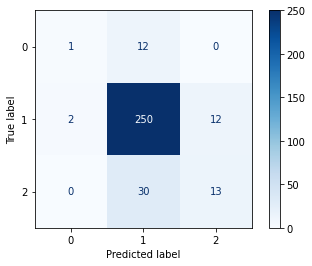

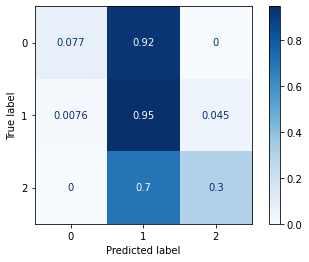

In [104]:
plt.figure(figsize=(3,2))
ConfusionMatrixDisplay.from_predictions(y_test_cat_rw, y_pred, 
                                        #display_labels=['low', 'medium', 'high'], 
                                        cmap=plt.cm.Blues, 
                                        normalize=None)
plt.grid(False)
ConfusionMatrixDisplay.from_predictions(y_test_cat_rw, y_pred, 
                                        #display_labels=['low', 'medium', 'high'], 
                                        cmap=plt.cm.Blues, 
                                        normalize='true')
plt.grid(False)
plt.show()

In [98]:
precision = precision_score(y_test_cat_rw, y_pred, average='weighted')
recall = recall_score(y_test_cat_rw, y_pred, average='weighted')
f1 = f1_score(y_test_cat_rw, y_pred, average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}\n")

Precision: 0.7823928571428571
Recall: 0.83125
f1: 0.8004921726755218



***
***

## References

[1] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems 47(4):547-553. doi:10.1016/j.dss.2009.05.016 

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

[3] Scikit-learn developers, https://scikit-learn.org/stable/modules/preprocessing.html

[4] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol

[5] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

[6] Should we apply normalization to test data as well? https://datascience.stackexchange.com/a/27616

[7] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:223

[8] https://stats.stackexchange.com/a/69159 Why do we need to normalize data before principal component analysis (PCA)?

[9] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:227

[10] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:233  #### LDA good to reduce dimensionality before another classifcation algorithm such as SVM

[11] https://scikit-learn.org/stable/modules/preprocessing.html Standardization, or mean removal and variance scaling

[12] https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html sklearn.discriminant_analysis.LinearDiscriminantAnalysis "The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix."

[13] https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

[14] https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#standardscaler

[15] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

[16] https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

[17] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[18] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol: p: 220-221, 226-117

[19] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol: p: 220-223